# Converting a trained model to tflite
https://www.tensorflow.org/lite/microcontrollers/build_convert#model_conversion

# Convert model to tflite

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
directory = '/media/atanu/B0F47788F4774F98/Educational/COURSES/semester4/Microprocessor/project/DataSet/compressed/SmallData/'
training_spectrogram = np.load(directory+'training_spectrogram.npz')
validation_spectrogram = np.load(directory+'validation_spectrogram.npz')
test_spectrogram = np.load(directory+'test_spectrogram.npz')

X_train = training_spectrogram['X']
X_validate = validation_spectrogram['X']
X_test = test_spectrogram['X']

complete_train_X = np.concatenate((X_train, X_validate, X_test))
# complete_train_X = X_validate

In [11]:
Y_train_cats = training_spectrogram['Y']
Y_validate_cats = validation_spectrogram['Y']
Y_test_cats = test_spectrogram['Y']

Y_train = tf.one_hot(Y_train_cats, len(command_words))
Y_validate = tf.one_hot(Y_validate_cats, len(command_words))
Y_test = tf.one_hot(Y_test_cats, len(command_words))


complete_train_Y = np.concatenate((Y_train, Y_validate, Y_test))

In [3]:
# List of the words in categorical order
command_words = [
    'zero',
    'one',
    'two',
    'three',
    'four',
    'five',
    'six',
    'seven',
    'eight',
    'nine',
    'tree',
    'bird',
    'cat',
    'dog',
    'happy',
    'house',
    'wow',
    '_invalid',
]

In [4]:
converter2 = tf.lite.TFLiteConverter.from_saved_model("fully_trained(.8807).model")
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for i in range(0, len(complete_train_X), 100):
        # Get sample input data as a numpy array in a method of your choosing.
        yield [complete_train_X[i:i+100]]
converter2.representative_dataset = representative_dataset_gen
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter2.convert()

In [8]:
import itertools


def plot_confusion_matrix(cm, class_names):
    """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
    cm = cm.numpy()
    # Normalize the confusion matrix.
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
#     return figure

In [9]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]
  
  newpre=[]
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    newpre.append(interpreter.get_tensor(output_details["index"])[0])

  return newpre

In [10]:
predictions = predict_tflite(tflite_quant_model, complete_train_X )

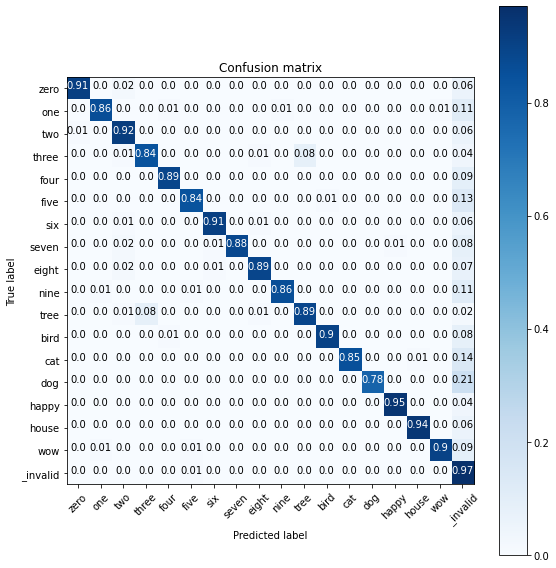

In [12]:
cm = tf.math.confusion_matrix(
    labels=tf.argmax(complete_train_Y, 1), predictions=tf.argmax(predictions, 1)
)

plot_confusion_matrix(cm, command_words)

In [13]:
open("converted_model.tflite", "wb").write(tflite_quant_model)

160720

# To convert to C++
This will run a command line too to convert out tflite model into C code.

In [ ]:
!xxd -i converted_model.tflite > model_data.cc